# Setup

In [1]:
import os
from pathlib import Path

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive-CoDec':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

In [2]:
# Download dataset
# from huggingface_hub import snapshot_download
# snapshot_download(repo_id="EMERGE-lab/GPUDrive_mini", repo_type="dataset", local_dir="data/processed")

In [3]:
import torch
import dataclasses
import mediapy
from huggingface_hub import PyTorchModelHubMixin
from huggingface_hub import ModelCard
from gpudrive.networks.late_fusion import NeuralNet

from gpudrive.env.config import EnvConfig
from gpudrive.env.env_torch import GPUDriveTorchEnv, GPUDriveConstrualEnv
from gpudrive.visualize.utils import img_from_fig
from gpudrive.env.dataset import SceneDataLoader
from gpudrive.utils.config import load_config

from copy import deepcopy
from functools import cache
from os import listdir
import json

from scipy.special import softmax
import numpy as np
import math
from itertools import combinations

from typing import Any, List, Tuple

/home/sbanerjee/PyEnvs/gpuDrive/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: module compiled against ABI version 0x1000009 but this version of numpy is 0x2000000

RuntimeError: module compiled against ABI version 0x1000009 but this version of numpy is 0x2000000

2025-04-12 21:53:34.392796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744509214.411152  108287 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744509214.416820  108287 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744509214.435758  108287 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744509214.435780  108287 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744509214.435781  108287 computation_placer.cc:177] computation placer alr

RuntimeError: module compiled against ABI version 0x1000009 but this version of numpy is 0x2000000

### Configs

In [4]:
# Configs model has been trained with
config = load_config("examples/experimental/config/reliable_agents_params")
print(config)

# datase_path='data/processed/examples'
# datase_path='data/processed/training'
datase_path = 'data/processed/construal'

max_agents = config.max_controlled_agents
num_parallel_envs = 5
total_envs = 5
device = "cpu" # cpu just because we're in a notebook
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Other changes to variables
config.max_controlled_agents = 1    # Control only the first vehicle in the environment
total_envs = min(total_envs, len(listdir(datase_path)))

{'max_controlled_agents': 64, 'ego_state': True, 'road_map_obs': True, 'partner_obs': True, 'norm_obs': True, 'remove_non_vehicles': True, 'lidar_obs': False, 'reward_type': 'weighted_combination', 'collision_weight': -0.75, 'off_road_weight': -0.75, 'goal_achieved_weight': 1.0, 'dynamics_model': 'classic', 'collision_behavior': 'ignore', 'dist_to_goal_threshold': 2.0, 'polyline_reduction_threshold': 0.1, 'sampling_seed': 42, 'obs_radius': 50.0, 'action_space_steer_disc': 13, 'action_space_accel_disc': 7, 'init_mode': 'all_non_trivial', 'vbd_in_obs': False}


### Make environment

In [5]:
# Create data loader
train_loader = SceneDataLoader(
    root=datase_path,
    batch_size=num_parallel_envs,
    dataset_size=max(total_envs,num_parallel_envs),
    sample_with_replacement=False,
)

# Set params
env_config = dataclasses.replace(
    EnvConfig(),
    ego_state=config.ego_state,
    road_map_obs=config.road_map_obs,
    partner_obs=config.partner_obs,
    reward_type=config.reward_type,
    norm_obs=config.norm_obs,
    dynamics_model=config.dynamics_model,
    collision_behavior=config.collision_behavior,
    dist_to_goal_threshold=config.dist_to_goal_threshold,
    polyline_reduction_threshold=config.polyline_reduction_threshold,
    remove_non_vehicles=config.remove_non_vehicles,
    lidar_obs=config.lidar_obs,
    disable_classic_obs=config.lidar_obs,
    obs_radius=config.obs_radius,
    steer_actions = torch.round(
        torch.linspace(-torch.pi, torch.pi, config.action_space_steer_disc), decimals=3  
    ),
    accel_actions = torch.round(
        torch.linspace(-4.0, 4.0, config.action_space_accel_disc), decimals=3
    ),
)

# |Make env
# env = GPUDriveTorchEnv(
#     config=env_config,
#     data_loader=train_loader,
#     max_cont_agents=config.max_controlled_agents,
#     device=device,
# )

# |Make env
env = GPUDriveConstrualEnv(
    config=env_config,
    data_loader=train_loader,
    max_cont_agents=config.max_controlled_agents,
    device=device,
)

In [6]:
env.data_batch

['data/processed/construal/tfrecord-00101-of-01000_71.json',
 'data/processed/construal/tfrecord-00117-of-01000_240.json',
 'data/processed/construal/tfrecord-00143-of-01000_179.json',
 'data/processed/construal/tfrecord-00144-of-01000_130.json',
 'data/processed/construal/tfrecord-00183-of-01000_301.json']

### Load pre-trained agent via Hugging Face hub


In [7]:
sim_agent = NeuralNet.from_pretrained("daphne-cornelisse/policy_S10_000_02_27")

In [8]:
type(sim_agent)

gpudrive.networks.late_fusion.NeuralNet

In [9]:
# Agent has an action dimension of 91: 13 steering wheel angle discretizations x 9 acceleration discretizations
sim_agent.action_dim

91

In [10]:
# Size of flattened observation vector
sim_agent.obs_dim

2984

In [11]:
# Some other info
card = ModelCard.load("daphne-cornelisse/policy_S10_000_02_27")
card.data.tags

['ffn', 'model_hub_mixin', 'pytorch_model_hub_mixin']

In [12]:
# Model architecture
#agent

In [13]:
# Weights 
#agent.state_dict()

In [14]:
os.listdir('data/processed/construal')

['tfrecord-00751-of-01000_212.json',
 'tfrecord-00268-of-01000_436.json',
 'tfrecord-00117-of-01000_240.json',
 'tfrecord-00979-of-01000_196.json',
 'tfrecord-00642-of-01000_89.json',
 'tfrecord-00144-of-01000_130.json',
 'tfrecord-00480-of-01000_195.json',
 'tfrecord-00143-of-01000_179.json',
 'tfrecord-00568-of-01000_107.json',
 'tfrecord-00441-of-01000_20.json',
 'tfrecord-00308-of-01000_303.json',
 'tfrecord-00796-of-01000_413.json',
 'tfrecord-00183-of-01000_301.json',
 'tfrecord-00644-of-01000_274.json',
 'tfrecord-00263-of-01000_345.json',
 'tfrecord-00792-of-01000_81.json',
 'tfrecord-00852-of-01000_73.json',
 'tfrecord-00558-of-01000_166.json',
 'tfrecord-00802-of-01000_437.json',
 'tfrecord-00690-of-01000_339.json',
 'tfrecord-00698-of-01000_451.json',
 'tfrecord-00342-of-01000_159.json',
 'tfrecord-00101-of-01000_71.json',
 'tfrecord-00402-of-01000_136.json',
 'tfrecord-00661-of-01000_170.json']

## Compare Models (Average Displacement Error)

## Compare Models (log likelihood)

TODO:
1. X - Use logits for action distribution
2. X - Get list of moving vehicles for construal masks
3. Write function to form contruals
4. Find waypoint trained models to get state-action pairs
5. Use state-action pairs to calculate loss

In [ ]:
# Set construal config
construal_size = 1
observed_agents_count = max_agents - 1    # Agents observed except self (used for vector sizes)
sample_size = 1                     # Number of samples to calculate expected utility of a construal

### Define Support Functions

In [16]:
def get_moving_vehicles(all_veh_objs, first_only = False):
    '''Create list of all moving vehicles in an environment

    Args:
        all_veh_objs: A list of vehicle objects in the environment
        first_only: breaks the loop after finding the first moving vehicle and only returns details for that object.

    Returns:
        A list or a single vehicle objects.
    '''
    moving_veh_list = []
    for i, obj in enumerate(all_veh_objs):
        all_velocities = [[veldict['x'],veldict['y']] for veldict in obj['velocity'] if veldict['x']!=-10000] # -10000 velocities mean object no longer exists
        all_velocities = [item for sublist in all_velocities for item in sublist] # Flatten list
        total_velocity = sum(all_velocities)/len(all_velocities) # Get avg velocity accross dimensions
        if abs(total_velocity) > 0:
            obj['index'] = i
            moving_veh_list.append(obj)
            if first_only: break
    return moving_veh_list

In [17]:
# TODO: Might no longer be useful
def transform_veh_indices(index_list, sim_env):
    '''
    Convert JSON indices to simulator indices

    Args:
        index_list: Source object list with all necessary details
        first_only: Simulator environment with all necessary details

    Returns:
        A list containing the indices (for the environment) of moving vehicles.
    '''
    pass

In [18]:
@cache
def get_construals(total_obs_count: int, target_obj_indices: tuple, construal_size: int):
    '''
    Create construed masks based on complete mask and objects of interest

    Args:
        total_obs_count: Total number of observed objects (used to determine length of mask)
        target_obj_indices: A list of indices containing all objects of interest in the bollean list
        construal_size: Size of each contrual

    Returns:
        Dictionary with construal indices as keys and coorresponding masks (boolean lists) as values.
            The dictionary also containts a default entry for '[]', with no onbservable object
    '''
    construal_size = construal_size if construal_size < len(target_obj_indices) else len(target_obj_indices)
    construal_indices_list = combinations(target_obj_indices, construal_size)
    construal_info = dict()
    for construal_num, construal_indices in enumerate(construal_indices_list):
        # |Mask all non-contrual target objects
        # curr_mask = [True if i in target_obj_indices else False for i in range(total_obs_count)]  # Mask all target objects
        # curr_mask = [False if i in construal_indices else val for i, val in enumerate(curr_mask)]  # Unmask objects in construal
        # |OR
        curr_mask = [True if i in target_obj_indices and i not in construal_indices else False for i in range(total_obs_count)]
        construal_info[construal_num] = (construal_indices, curr_mask)
    construal_info['default'] = ((), [False,]*total_obs_count)    # Default construal where all vehicles are observed
    return construal_info


def get_construal_byIndex(total_obs_count, target_obj_indices, construal_size, indx):
    '''
    Create construed masks based on complete mask and objects of interest

    Args:
        total_obs_count: Total number of observed objects (used to determine length of mask)
        target_obj_indices: A list of indices containing all objects of interest in the bollean list
        construal_size: Size of each contrual
        indx: The construal number

    Returns:
        Tuple of construal object indices and coorresponding mask (boolean list).
        If index is greater than number of constrauls it returns a default value, with no observable objects
    '''
    if indx in get_construals(total_obs_count, target_obj_indices, construal_size).keys():
        return get_construals(total_obs_count, target_obj_indices, construal_size)[indx]
    else:
        # If index out of bounds, return default construal
        return get_construals(total_obs_count, target_obj_indices, construal_size)['default']

### Obtain Preliminary info

Get moving vehicles list

In [19]:
moving_veh_mask = GPUDriveConstrualEnv(
    config=env_config,
    data_loader=train_loader,
    max_cont_agents=max_agents,
    device=device,
).cont_agent_mask

Get construal (Selection by bins) values [Depricated]

In [ ]:
# |Construal Selection by Bins
limit_observed_agents = 40          # Maximum nember of agents to observe (used for loop counts)

construal_values = {}               # Dictionary that contains the expected utility per construal
for const_num in range(math.ceil(limit_observed_agents/construal_size)):
    # Repeat rollout for each construal

    next_obs = env.reset()
    control_mask = env.cont_agent_mask
    # print("Observation shape: ", next_obs.shape)
    frames = {f"env_{i}-constr_{const_num}": [] for i in range(total_envs)}

    ## Define observation mask for construal
    construal_masks = [True]*observed_agents_count     # Mask all values
    mask_start_indx = int(const_num*construal_size)
    mask_end_indx = min(observed_agents_count, int( ((const_num+1)*construal_size)-1 ))
    # if mask_end_indx >= limit_observed_agents:
    #     break
    print("Construal indices: ", mask_start_indx, "-", mask_end_indx)
    construal_masks[mask_start_indx:mask_end_indx] = [False]*(mask_end_indx-mask_start_indx)     # Do not mask values for objects to be observed
    
    curr_samples = []
    for i in range(sample_size):
        print("\tsample ", i)
        next_obs = env.reset()
        for time_step in range(env.episode_len):
            ## Roll out policy for a specific construal
            print(f"\r\t\tStep: {time_step}", end="", flush=True)

            ### Predict actions
            action, _, _, _, _ = sim_agent(
                next_obs[control_mask], deterministic=False
            )
            action_template = torch.zeros(
                (total_envs, max_agents), dtype=torch.int64, device=device
            )
            action_template[control_mask] = action.to(device)

            ### Step
            env.step_dynamics(action_template)

            ### Render
            sim_states = env.vis.plot_simulator_state(
                env_indices=list(range(total_envs)),
                time_steps=[time_step]*total_envs,
                zoom_radius=70,
            )
            
            for i in range(total_envs):
                frames[f"env_{i}-constr_{const_num}"].append(img_from_fig(sim_states[i])) 

            # next_obs = env.get_obs(obs_mask)
            next_obs = env.get_obs(partner_mask=construal_masks)
            reward = env.get_rewards()
            done = env.get_dones()
            info = env.get_infos()
            
            if done.all():
                break
        print() # Change to new line after step prints
            
        curr_samples.append(reward[control_mask].tolist())
    construal_values[(mask_start_indx,mask_end_indx)] = np.array([sum(x)/sample_size for x in zip(*curr_samples)])

    ## Save animations
    # mediapy.set_show_save_dir('./sim_vids')
    # mediapy.show_videos(frames, fps=15, width=500, height=500, columns=2, codec='gif')

# env.close()
print("\nExpected utility by contrual: ", construal_values)

Construal indices:  0 - 4
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  5 - 9
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  10 - 14
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  15 - 19
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  20 - 24
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  25 - 29
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  30 - 34
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  35 - 39
	sample  0

```Expected utility by contrual:  {(0, 4): array([1. , 1. , 1. , 1. , 0.8]), (5, 9): array([1., 1., 1., 1., 1.]), (10, 14): array([1., 1., 1., 1., 1.]), (15, 19): array([1., 1., 1., 1., 1.]), (20, 24): array([1., 1., 1., 1., 1.]), (25, 29): array([1., 1., 1., 1., 1.]), (30, 34): array([1. , 0.8, 1. , 1. , 1. ]), (35, 39): array([1., 1., 1., 1., 1.])}```

Get construal (Selection by moving vehicles) values

In [20]:

moving_veh_indices = [tuple([i for i, val in enumerate(mask) if val]) for mask in moving_veh_mask]

construal_masks = [] 
for const_num in range(15):
    curr_masks = []
    for scene_num, _ in enumerate(env.data_batch):
        curr_masks.append( get_construal_byIndex(max_agents, moving_veh_indices[scene_num], 2, const_num) )
    construal_masks.append(curr_masks)



In [26]:
construal_masks = construal_masks[1]

In [27]:
tmp = []
for mask_info in construal_masks:
    mask_indices, mask = mask_info
    curr_masks = [list(mask) for _ in range(len(mask))]     # Create multiple copies of the mask, one obervation for each vehicle
    [msk.pop(i) for i, msk in enumerate(curr_masks)]
    tmp.append(curr_masks)

In [28]:
np.array(tmp).shape

(5, 64, 63)

In [ ]:
########################################### OLD LOGIC [IGNORE] ###########################################
# # |Get moving vehicle indices from JSON file
# moving_veh_lists = {}
# for fl_path in env.data_batch:
#     with open(fl_path, 'r') as opn_file:
#         data = json.load(opn_file)
#     moving_veh_lists[fl_path] = get_moving_vehicles(data['objects'])

# # TODO:|Transform JSON indices to env indices
# moving_veh_indices = {fl_path:transform_veh_indices(json_objs,env) for fl_path,json_objs in moving_veh_lists.items()}
#####################################################################################################################

moving_veh_indices = [tuple([i for i, val in enumerate(mask) if val]) for mask in moving_veh_mask]
print("Indices of moving vehicles (by scene): ", moving_veh_indices)
control_mask = env.cont_agent_mask

# |Simulate under construed observation spaces
construal_values = {}               # Dictionary that contains the expected utility per construal
for const_num in range(math.comb(observed_agents_count,construal_size)):
    # |Repeat rollout for each construal

    next_obs = env.reset()
    # print("Observation shape: ", next_obs.shape)
    frames = {f"env_{i}-constr_{const_num}": [] for i in range(total_envs)}

    #2# |Define observation mask for construal
    construal_masks = [] 
    for scene_num, _ in enumerate(env.data_batch):
        construal_masks.append( get_construal_byIndex(max_agents, moving_veh_indices[scene_num], construal_size, const_num) )
    #3# |get_construal_byIndex produces masks of shape [scenes,objs], reshape to [scenes,objs,obs]
    tmp = []
    mask_indices = ()
    for mask_info in construal_masks:
        curr_indices, mask = mask_info
        curr_masks = [list(mask) for _ in range(len(mask))]     # Create multiple copies of the mask, one for each vehicle
        [msk.pop(i) for i, msk in enumerate(curr_masks)]        # Remove entry in the mask that corresponds to the vehicle
        tmp.append(curr_masks)
        mask_indices += (tuple(curr_indices),)
    construal_masks = tmp
    
    curr_samples = []
    for i in range(sample_size):
        print("\tsample ", i)
        next_obs = env.reset()
        for time_step in range(env.episode_len):
            #2# |Roll out policy for a specific construal
            print(f"\r\t\tStep: {time_step}", end="", flush=True)

            #3# |Predict actions
            action, _, _, _, _ = sim_agent(
                next_obs[control_mask], deterministic=False
            )
            action_template = torch.zeros(
                (total_envs, max_agents), dtype=torch.int64, device=device
            )
            action_template[control_mask] = action.to(device)

            #3# |Step
            env.step_dynamics(action_template)

            #3# |Render
            sim_states = env.vis.plot_simulator_state(
                env_indices=list(range(total_envs)),
                time_steps=[time_step]*total_envs,
                zoom_radius=70,
            )
            
            for i in range(total_envs):
                frames[f"env_{i}-constr_{const_num}"].append(img_from_fig(sim_states[i])) 

            # next_obs = env.get_obs(obs_mask)
            next_obs = env.get_obs(partner_mask=construal_masks)
            reward = env.get_rewards()
            done = env.get_dones()
            info = env.get_infos()
            
            if done.all():
                break
        print() # Change to new line after step prints
            
        curr_samples.append(reward[control_mask].tolist())
    construal_values[mask_indices] = np.array([sum(x)/sample_size for x in zip(*curr_samples)])
    print("Processed masks: ", mask_indices)
    if all([mask[0] == () for mask in construal_masks]):
        #3# |Break loop once list of construals for all scenarios have been exhausted
        break

    #2# |Save animations
    # mediapy.set_show_save_dir('./sim_vids')
    # mediapy.show_videos(frames, fps=15, width=500, height=500, columns=2, codec='gif')

# env.close()
print("\nExpected utility by contrual: ", construal_values)

Indices of moving vehicles (by scene):  [(0, 1, 5, 9, 10, 42, 43), (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20), (0, 7, 59), (0, 18, 27, 28, 36)]
	sample  0
		Step: 90
[[1.0, 1.0, 1.0, 1.0, 1.0]]
Processed masks:  ((0, 1, 5, 9, 10, 42, 43), (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15), (0, 7, 59), (0, 18, 27, 28, 36))
{((0, 1, 5, 9, 10, 42, 43), (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15), (0, 7, 59), (0, 18, 27, 28, 36)): array([1., 1., 1., 1., 1.])}
	sample  0
		Step: 71

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f9a1a8e0e90>>
Traceback (most recent call last):
  File "/home/sbanerjee/PyEnvs/gpuDrive/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


		Step: 77

In [21]:
reward

tensor([[ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  1.0000,
          1.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000, 

In [22]:
control_mask

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False

In [27]:
construal_values

{((0, 1, 5, 9, 10, 42, 43),
  (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16),
  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
  (0, 7, 59),
  (0, 18, 27, 28, 36)): array([], dtype=float64),
 ((),
  (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17),
  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16),
  (),
  ()): array([], dtype=float64),
 ((),
  (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17),
  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17),
  (),
  ()): array([], dtype=float64),
 ((),
  (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17),
  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18),
  (),
  ()): array([], dtype=float64)}

In [ ]:
construal_cost = 1/len(construal_values)
pi_CgivS0 = {constr:vals-construal_cost for constr, vals in construal_values}

### Get State-Action Pairs

In [ ]:
st_act_pairs = get for each environment

### Perform Evaluation

In [ ]:
def evaluate_ADE(agent_traj: List[Tuple], true_traj: List[Tuple]):
    """
    Compute Average Displacement Error
    """
    pass


In [ ]:
next_obs = env.reset()


for st, act in st_act_pairs:
    control_mask = env.cont_agent_mask

    # Get general policy
    next_obs = env.get_obs()

    #2# Predict actions
    action, _, _, _, action_probs = sim_agent(
        next_obs[control_mask], deterministic=False
    )
    action_template = torch.zeros(
        (total_envs, max_agents), dtype=torch.int64, device=device
    )
    action_template[control_mask] = action.to(device)
    
    pi_AgivS = 

    # Get construal policies
    pi_c_AgivS = {}
    for const_num in range(math.ceil(limit_observed_agents/construal_size)):
        #2# Define observation mask for construal
        construal_masks = [False]*observed_agents_count
        mask_start_indx = int(const_num*construal_size)
        mask_end_indx = min(observed_agents_count, int( ((const_num+1)*construal_size)-1 ))
        construal_masks[mask_start_indx:mask_end_indx] = [True]*(mask_end_indx-mask_start_indx)

        next_obs = env.get_obs(partner_mask=construal_masks)

        #2# Predict actions
        action, logprob, entropy, value, action_probs = sim_agent(
            next_obs[control_mask], deterministic=False
        )
        action_template = torch.zeros(
            (total_envs, max_agents), dtype=torch.int64, device=device
        )
        action_template[control_mask] = action.to(device)

        pi_c_AgivS[(mask_start_indx,mask_end_indx)] = 



pi_VGC = sum([pi_CgivS0[constr] * pi_c_AgivS[constr] for constr, _ in construal_values])
lambda_VGC = -sum([math.log()])
lambda_gen = -sum([math.log()])



### OLD LOGIC ###
for st, act in st_act_pairs:
    control_mask = env.cont_agent_mask

    # Get general policy
    next_obs = env.get_obs()

    #2# Predict actions
    action, logprob, entropy, value, logits = sim_agent(
        next_obs[control_mask], deterministic=False
    )
    action_template = torch.zeros(
        (total_envs, max_agents), dtype=torch.int64, device=device
    )
    action_template[control_mask] = action.to(device)
    
    #2# Set probability of taken actions to 1
    action_probs = np.zeros((total_envs, max_agents, 91), dtype=np.int64)
    temp = action_template.numpy()
    temp = temp.nonzero() + (temp[temp.nonzero()],) # actions as distribution indices
    action_probs[temp] = 1

    pi_AgivS = 

    # Get construal policies
    pi_c_AgivS = {}
    for const_num in range(math.ceil(limit_observed_agents/construal_size)):
        #2# Define observation mask for construal
        construal_masks = [False]*observed_agents_count
        mask_start_indx = int(const_num*construal_size)
        mask_end_indx = min(observed_agents_count, int( ((const_num+1)*construal_size)-1 ))
        construal_masks[mask_start_indx:mask_end_indx] = [True]*(mask_end_indx-mask_start_indx)

        next_obs = env.get_obs(partner_mask=construal_masks)

        #2# Predict actions
        action, logprob, entropy, value, logits = sim_agent(
            next_obs[control_mask], deterministic=False
        )
        action_template = torch.zeros(
            (total_envs, max_agents), dtype=torch.int64, device=device
        )
        action_template[control_mask] = action.to(device)
    
        #2# Set probability of taken actions to 1
        action_probs = np.zeros((total_envs, max_agents, 91), dtype=np.int64)
        temp = action_template.numpy()
        temp = temp.nonzero() + (temp[temp.nonzero()],) # actions as distribution indices
        action_probs[temp] = 1

        pi_c_AgivS[(mask_start_indx,mask_end_indx)] = 



# Reference Code

### Construal Simulation

In [ ]:
import math

In [ ]:
construal_size = 5
observed_agents_count = max_agents - 1    # Agents observed except self (used for vector sizes)
limit_observed_agents = 40          # Maximum nember of agents to observe (used for loop counts)
construal_values = {}               # Dictionary that contains the expected utility per construal
sample_size = 5                     # Number of samples to calculate expected utility of a construal
for const_num in range(math.ceil(limit_observed_agents/construal_size)):
    # Repeat rollout for each construal

    next_obs = env.reset()
    control_mask = env.cont_agent_mask
    # print("Observation shape: ", next_obs.shape)
    frames = {f"env_{i}-constr_{const_num}": [] for i in range(total_envs)}

    ## Define observation mask for construal
    construal_masks = [False]*observed_agents_count
    mask_start_indx = int(const_num*construal_size)
    mask_end_indx = min(observed_agents_count, int( ((const_num+1)*construal_size)-1 ))
    # if mask_end_indx >= limit_observed_agents:
    #     break
    print("Construal indices: ", mask_start_indx, "-", mask_end_indx)
    construal_masks[mask_start_indx:mask_end_indx] = [True]*(mask_end_indx-mask_start_indx)
    
    curr_samples = []
    for i in range(sample_size):
        print("\tsample ", i)
        next_obs = env.reset()
        for time_step in range(env.episode_len):
            ## Roll out policy for a specific construal
            print(f"\r\t\tStep: {time_step}", end="", flush=True)

            ### Predict actions
            action, logprob, entropy, value, logits = sim_agent(
                next_obs[control_mask], deterministic=False
            )
            action_template = torch.zeros(
                (total_envs, max_agents), dtype=torch.int64, device=device
            )
            action_template[control_mask] = action.to(device)

            ### Step
            env.step_dynamics(action_template)

            ### Render
            sim_states = env.vis.plot_simulator_state(
                env_indices=list(range(total_envs)),
                time_steps=[time_step]*total_envs,
                zoom_radius=70,
            )
            
            for i in range(total_envs):
                frames[f"env_{i}-constr_{const_num}"].append(img_from_fig(sim_states[i])) 

            # next_obs = env.get_obs(obs_mask)
            next_obs = env.get_obs(partner_mask=construal_masks)
            reward = env.get_rewards()
            done = env.get_dones()
            info = env.get_infos()
            
            if done.all():
                break
        print() # Change to new line after step prints
            
        curr_samples.append(reward[control_mask].tolist())
    construal_values[(mask_start_indx,mask_end_indx)] = [sum(x)/sample_size for x in zip(*curr_samples)]

    ## Save animations
    # mediapy.set_show_save_dir('./sim_vids')
    # mediapy.show_videos(frames, fps=15, width=500, height=500, columns=2, codec='gif')

# env.close()
print("\nExpected utility by contrual: ", construal_values)

Construal indices:  0 - 5
	sample  0
		Step: 0

		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  5 - 10
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  10 - 15
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  15 - 20
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  20 - 25
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  25 - 30
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  30 - 35
	sample  0
		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90
Construal indices:  35 - 40
	sample  0
		Step: 90
	sample  1
		Step: 90
	s

In [ ]:
# Run the simulation with only 1 observed car

import math

construal_size = 39
observed_agents_count = max_agents - 1    # Agents observed except self (used for vector sizes)
limit_observed_agents = 40          # Maximum nember of agents to observe (used for loop counts)
construal_values = {}               # Dictionary that contains the expected utility per construal
sample_size = 5                     # Number of samples to calculate expected utility of a construal
for const_num in range(math.ceil(limit_observed_agents/construal_size)):
    # Repeat rollout for each construal size

    next_obs = env.reset()
    control_mask = env.cont_agent_mask
    # print("Observation shape: ", next_obs.shape)
    frames = {f"env_{i}-constr_{const_num}": [] for i in range(total_envs)}

    ## Define observation mask for construal
    construal_masks = [False]*observed_agents_count
    mask_start_indx = int(const_num*construal_size)
    mask_end_indx = min(observed_agents_count, int((const_num+1)*construal_size))
    # if mask_end_indx >= limit_observed_agents:
    #     break
    print("Construal indices: ", mask_start_indx, "-", mask_end_indx)
    construal_masks[mask_start_indx:mask_end_indx] = [True]*(mask_end_indx-mask_start_indx)
    
    curr_samples = []
    for i in range(sample_size):
        print("\tsample ", i)
        next_obs = env.reset()
        for time_step in range(env.episode_len):
            ## Roll out policy for a specific construal
            print(f"\r\t\tStep: {time_step}", end="", flush=True)

            ### Predict actions
            action, _, _, _, _ = sim_agent(
                next_obs[control_mask], deterministic=False
            )
            action_template = torch.zeros(
                (total_envs, max_agents), dtype=torch.int64, device=device
            )
            action_template[control_mask] = action.to(device)

            ### Step
            env.step_dynamics(action_template)

            ### Render
            sim_states = env.vis.plot_simulator_state(
                env_indices=list(range(total_envs)),
                time_steps=[time_step]*total_envs,
                zoom_radius=70,
            )
            
            for i in range(total_envs):
                frames[f"env_{i}-constr_{const_num}"].append(img_from_fig(sim_states[i])) 

            # next_obs = env.get_obs(obs_mask)
            next_obs = env.get_obs(partner_mask=construal_masks)
            reward = env.get_rewards()
            done = env.get_dones()
            info = env.get_infos()
            
            if done.all():
                break
        print() # Change to new line after step prints
            
        curr_samples.append(reward[control_mask].tolist())
    construal_values[(mask_start_indx,mask_end_indx)] = [sum(x)/sample_size for x in zip(*curr_samples)]
    break
    ## Save animations
    # mediapy.set_show_save_dir('./sim_vids')
    # mediapy.show_videos(frames, fps=15, width=500, height=500, columns=2, codec='gif')

# env.close()
print("\nExpected utility by contrual: ", construal_values)

Construal indices:  0 - 39
	sample  0
		Step: 0

		Step: 90
	sample  1
		Step: 90
	sample  2
		Step: 90
	sample  3
		Step: 90
	sample  4
		Step: 90

Expected utility by contrual:  {(0, 39): [1.0, 1.0, 1.0, 1.0]}


### Original Rollout

In [17]:
next_obs = env.reset()

control_mask = env.cont_agent_mask

print(next_obs.shape)

frames = {f"env_{i}": [] for i in range(total_envs)}

for time_step in range(env.episode_len):
    print(f"\rStep: {time_step}", end="", flush=True)

    # Predict actions
    # action, logprob, entropy, value, logits = sim_agent(
    #     next_obs[control_mask], deterministic=False
    # )
    # action_template = torch.zeros(
    #     (total_envs, max_agents), dtype=torch.int64, device=device
    # )
    # action_template[control_mask] = action.to(device)

    # # Step
    # env.step_dynamics(action_template)
    actions = None
    env.step_dynamics(actions)

    # Render    
    sim_states = env.vis.plot_simulator_state(
        env_indices=list(range(total_envs)),
        time_steps=[time_step]*total_envs,
        zoom_radius=70,
    )
    
    for i in range(total_envs):
        frames[f"env_{i}"].append(img_from_fig(sim_states[i])) 

    next_obs = env.get_obs()
    reward = env.get_rewards()
    done = env.get_dones()
    info = env.get_infos()

    if done.all():
        break

# env.close()

torch.Size([5, 64, 2984])
Step: 0

Step: 13

KeyboardInterrupt: 


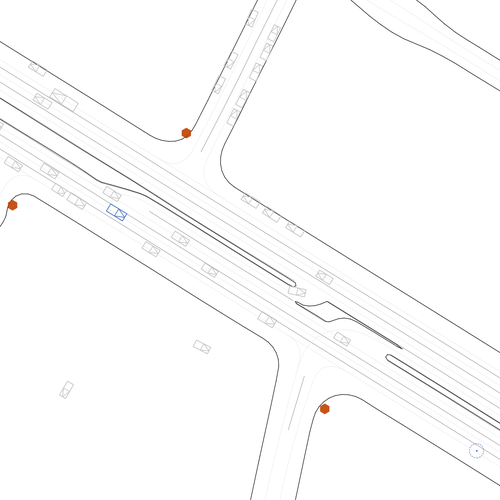
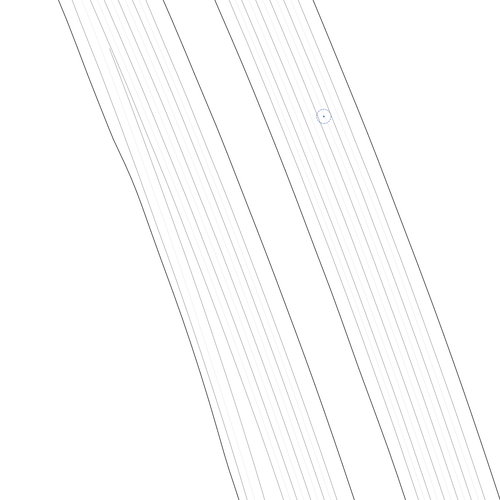
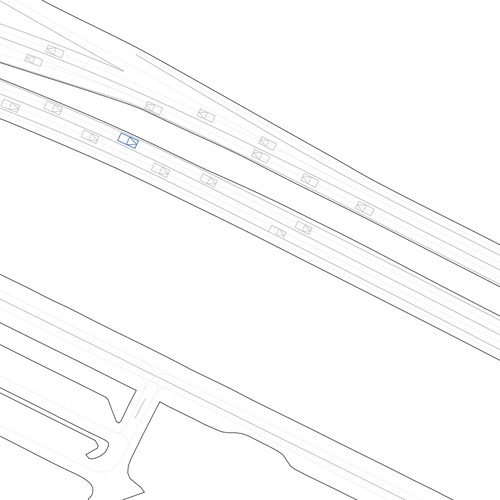
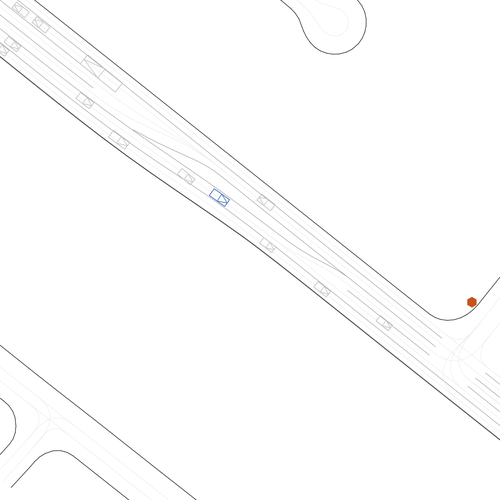
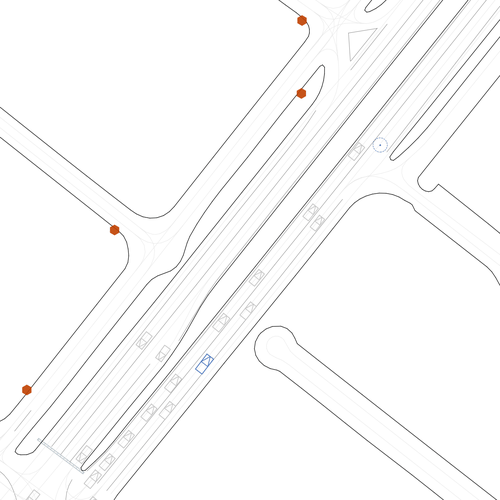

In [35]:
mediapy.set_show_save_dir('./sim_vids')
mediapy.show_videos(frames, fps=15, width=500, height=500, columns=2, codec='gif')

### Use the agent

In [12]:
next_obs = env.reset()

control_mask = env.cont_agent_mask

next_obs.shape

torch.Size([2, 64, 2984])

In [13]:
action, logprob, entropy, value = sim_agent(
    next_obs[control_mask], deterministic=False
)

In [14]:
action.shape, logprob.shape, entropy.shape, value.shape

(torch.Size([2]), torch.Size([2]), torch.Size([2]), torch.Size([2, 1]))

In [ ]:
curr_veh = control_mask.nonzero()[4]
control_mask[curr_veh[0], curr_veh[1]]
curr_veh